# One-Bit Music

In this notebook we will talk about quantization and oversampling and we will do so by taking a trip down memory lane to revisit the early days of sound effects in video games and home computers. We'll start from monophonic square waves, introduce polyphony by way of pulse-width modulation and finish with the basics of sigma-delta quantization.

![pacman](pacman.gif)

In [31]:
%pylab inline

import scipy.signal as sp
from scipy.io import wavfile
import IPython

IPython.display.Audio = lambda *args, **kwargs: None  # avoid generating wave data and inflate file size.

plt.rcParams["figure.figsize"] = (14,4)

Populating the interactive namespace from numpy and matplotlib


In [32]:
import os
import sys 

if os.name == 'nt':
    path = 'C:\\Users\\Wei\\Dropbox\\Coding\\notebooks\\專案\\待處理\\Waves\\bitbucket\\github\\codes'
else:
    path = '/home/wei/Dropbox/Coding/notebooks/專案/待處理/Waves/bitbucket/github/codes'
    
sys.path.append(path)
 
from waves.tools.dsp import *

## 1 - Square Waves

In the analog world the simplest "musical" waveform is the sinusoidal oscillation, since sinusoids describe the oscillatory behavior of physical objects such as strings, rods and air columns in pipes. 

![modes](modes.gif)

In the digital world, on the other hand, the simplest way to create a sound is to drive a loudspeaker with a two-level signal that alternates between two fixed voltage values. The resulting waveform is a square wave, which is the prototypical signal generated by an astable digital oscillator such as the simple circuit based on logic gates shown here: 

![astable](astable.png)

The samples of a discrete-time square wave take values over a set of only two possible values (high and low, or +1 and -1) and so each sample can be encoded using only one bit; this is smallest quantization granularity for a digital signal. 

### Early sound hardware

In the first digital consumer devices (such as early video games and home computers) the interfaces to the outside world were kept as simple as possible in order to minimize the cost of hardware. Early processors had only a few output data lines (usually 8), each one of which could be independently driven to a high or low level by setting or resetting the appropriate bit in an internal register. For the audio interface it was common to reserve a single data line, and drive the loudspeaker directly via the internal bit value: the only waveforms sent to the loudspeaker were therefore square waves. This simple setup had two great advantages:

#### a) low algorithmic complexity
A square wave with frequency $\omega_0$ can be easily generated mathematically by thresholding a sinusoidal function: 

$$
    x[n] = \begin{cases} 
        +1 & \mbox{if $\sin(\omega_0 n) \ge 0$} \\ 
        -1 & \mbox{if $\sin(\omega_0 n) \lt 0$} 
        \end{cases} 
$$ 

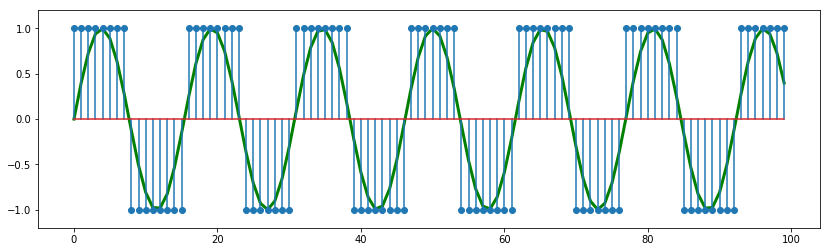

In [33]:
def square_wave_exact(w, N):
    return np.where(np.sin(np.arange(0, N) * w) >= 0, 1, -1)


N=100
w = .13 * np.pi

plt.figure(figsize=(14,4))
plt.plot(np.sin(np.arange(0, N) * w), 'g', linewidth=3)
plt.stem(square_wave_exact(w, 100))
plt.ylim(-1.2, 1.2);

While this is mathematically accurate, it requires the use of trigonometric computations, which were usually too expensive in terms of CPU cycles. On the other hand, consider the period (in samples) of the same square wave:

$$ P = \frac{2\pi}{\omega_0} $$

If $\omega_0 = 2\pi / P$ for $P \in \mathbb{N}$ then the period is equal to an integer number of samples and the square wave can be synthesized simply as 

$$ 
    x[n] = \begin{cases} 
        +1 & \mbox{if $(n \mod P) \le (P/2)$} \\ 
        -1 & \mbox{otherwise} 
        \end{cases} 
$$ 

If $2\pi/\omega_0$ is not an integer, we can simply try and use $P=\mbox{round}(2\pi/\omega_0)$. The rounding operation will cause a ***detuning*** of the waveform's pitch with respect to the nominal frequency; as the latter increases, the relative error in the rounded period will grow proportionately and the played notes will sound more and more out of tune; we will hear an example later. 

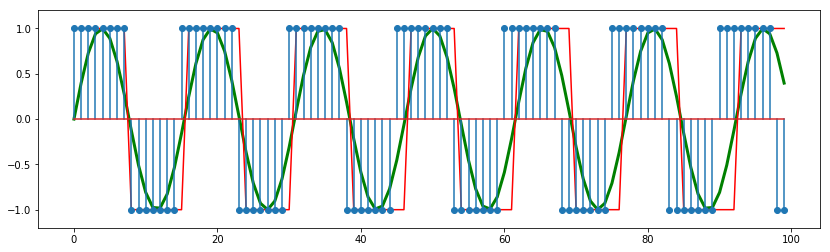

In [34]:
def square_wave_cheap(w, N):
    p = np.round(2 * np.pi / w)
    return np.where((np.arange(0, N) % p) >= (p/2), -1, 1)


# we plot the correct square wave in red to show the detuning of the "cheap" version
plt.figure(figsize=(14,4))
plt.plot(np.sin(np.arange(0, N) * w), 'g', linewidth=3)
plt.plot(square_wave_exact(w, 100), 'red')
plt.stem(square_wave_cheap(w, 100))
plt.ylim(-1.2, 1.2);

#### b) simple D/A conversion
The second advantage of a square wave is that it is a 1-bit signal and 1-bit signals can be applied directly to a loudspeaker via a simple zero-order interpolator. Basically, for 1-bit signals, the D/A converter can even be omitted entirely and the CPU data line can be used to drive the speaker. In the figure below, you can see the relevant portion of the schematics of the ZX Spectrum, one of the most popular home computers of the 80s; the loudspeaker is directly connected to pin 28 of the data bus:

![spectrum](spectrum.png)


## 2 - Five-Finger Exercise

OK, time to play some simple 1-bit music: for this we will need a function to convert pitch names to frequencies (we used the `note_to_freq` function in an earlier notebook so we will just load it from an auxiliary file) and a parser to read a sequence of notes and produced the appropriate square wave segments.

You should be able to recognize the tune...

In [35]:
from music import note_to_freq

def play_notes(melody, time_scale=1, rate=32000, wave_engine=square_wave_cheap):
    # melody is a tuple of pairs, each pair containing the pitch and the duration
    #  of each note; time_scale gives the base length of a note of unit duration 
    s = []
    for note in melody:
        f = 2 * np.pi * note_to_freq(note[0]) / float(rate)
        # 
        N = int(note[1] * rate * time_scale)
        if f > 0:
            s = np.concatenate((s, wave_engine(f, N)))
        else:
            s = np.concatenate((s, np.ones(N)))
    return s


tune = (('B4', 2), ('B5', 2), ('F#5', 2), ('D#5', 2), ('B5', 1), ('F#5', 3), ('D#5', 4), 
        ('C5', 2), ('C6', 2), ('G5', 2),  ('E5', 2),  ('C6', 1), ('G5', 3),  ('E5', 4),
        ('B4', 2), ('B5', 2), ('F#5', 2), ('D#5', 2), ('B5', 1), ('F#5', 3), ('D#5', 4), 
        ('D#5', 1), ('E5', 1), ('F5', 2), ('F5', 1), ('F#5', 1), ('G5', 2), ('G5', 1), 
        ('G#5', 1), ('A5', 2), ('B5', 4))

SF = 24000
jingle = play_notes(tune, time_scale=0.06, rate=SF)
IPython.display.Audio(jingle, rate=SF)

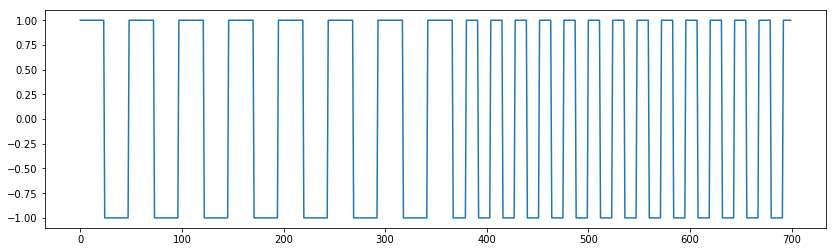

In [36]:
plt.plot(jingle[2500:3200]);

We can experience the limitations of the "cheap" square wave generator if we lower the sampling rate, so that the relative error in the period becomes bigger (this should also sound familiar to those who played with early video games):

In [37]:
SF=8000
IPython.display.Audio(play_notes(tune, time_scale=0.06, rate=SF), rate=SF)

We could try to ameliorate the detuning by using the precise square wave generator instead; if we do so, the pitches are now correct but we hear artifacts due to the fact that most notes cover a fractional number of periods; this "sound" as well should be familiar to vintage gamers):

In [38]:
SF=8000
IPython.display.Audio(play_notes(tune, time_scale=0.06, wave_engine=square_wave_exact, rate=SF), rate=SF)

## 3 - Two-part invention in B

If you recognized the tune, you also noticed that something is missing: indeed, the original PacMan jingle is not monophonic, it also contains a simple bass line. We can generate the bass as a separate files and sum it to the treble, to recover the full PacMan experience:

In [39]:
tune_bass = (('B2', 6), ('B3', 2), ('B2', 6), ('B3', 2), ('C3', 6), ('C4', 2), ('C3', 6), ('C4', 2), 
             ('B2', 6), ('B3', 2), ('B2', 6), ('B3', 2), 
             ('F#3', 4), ('G#3', 4), ('A#3', 4), ('B3', 4))

SF = 24000
pacman = jingle + play_notes(tune_bass, time_scale=0.06, rate=SF)
IPython.display.Audio(pacman, rate=SF)

The problem, however, is that the sum of two square waves is no longer a two-level square wave and therefore it cannot be represented with 1 bit per sample. We can see this if we plot the polyphonic PacMan waveform in detail:

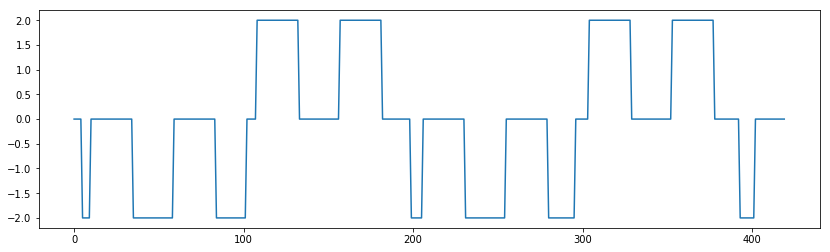

In [40]:
plt.figure(figsize=(14,4))
plt.plot(pacman[480:900])
plt.ylim(-2.2, 2.2);

You can see that the waveform now takes on three possible values: -2, 0, and 2. Since we will be checking more waveforms in the future, let's introduce some quick test functions:

In [41]:
def distinct_values(x):
    v = set()
    for k in x:
        v.add(k)
    return v


def is_two_level(x):
    v = distinct_values(x)
    print('the signal is', '' if len(v) == 2 else 'NOT', 'two-level; values:')
    print(sorted(list(v)))
        
        
# the monophonic tune is two-valued...
is_two_level(jingle)

# but the polyphonic tune is not!
is_two_level(pacman)

the signal is  two-level; values:
[-1.0, 1.0]
the signal is NOT two-level; values:
[-2.0, 0.0, 2.0]


At this point, a rather desperate approach could be to just ignore the extended output range and quantize the polyphonic signal to 1 bit:

In [42]:
sq = np.where(pacman >= 0, 1, -1)
print(distinct_values(sq))
IPython.display.Audio(sq , rate=SF)

{1, -1}


Interesting sound (once again: some old games sounded just like that), but not quite close to the original... ;) We need to be smarter.

## 4 - Intermission: dithering (or pulse width modulation)

The way to encode a polyphonic tune at one bit per sample requires four fundamental intuitions: 

#### a) duty cycle of a square wave

So far we have considered only *balanced* square waves: if the period of the wave is $P$ samples, we assumed that the signal would be +1 over the first $P/2$ samples and -1 for the second half of the period. However we can define *asymmetric* square waves of period $P$ where there are $D$ samples equal to +1 and $P-D$ samples equal to -1. The ratio $D/P$ is called the *duty cycle* of the square wave; an important thing for what follows is that the average value of one period of a square wave with duty cycle $C$ is $2C-1$. Clearly, for a balanced square wave $C=0.5$ and the average value is zero.

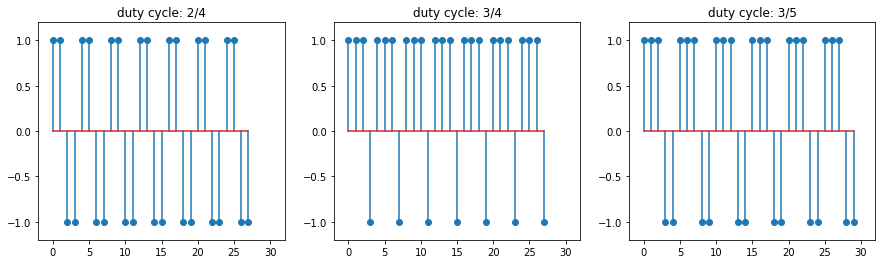

In [43]:
def square_wave_vdc(P, D, N):
    # build a variable duty cycle square wave
    # one period:
    chunk = -np.ones(P)
    chunk[:D] = 1
    
    # full wave
    sw = np.tile(chunk, int(N / P))
    
    return sw
    
def show_sqw_vdc(P, D):
    plt.stem(square_wave_vdc(P, D, 30))
    plt.ylim(-1.2, 1.2);
    plt.xlim(-2, 32)
    plt.title('duty cycle: ' + str(D) + '/' + str(P))

plt.figure(figsize = (15, 4))   
    
plt.subplot(1, 3, 1)    
show_sqw_vdc(4, 2)

plt.subplot(1, 3, 2)    
show_sqw_vdc(4, 3)

plt.subplot(1, 3, 3)      
show_sqw_vdc(5, 3)

#### b) lowpassing square waves
A lowpass filter always performs some kind of averaging; if we lowpass filter a square wave with duty cycle $C$, the output will tend to and oscillate around the average of the wave's period, i.e. around the value $2C-1$. We can test this easily by using a leaky integrator:

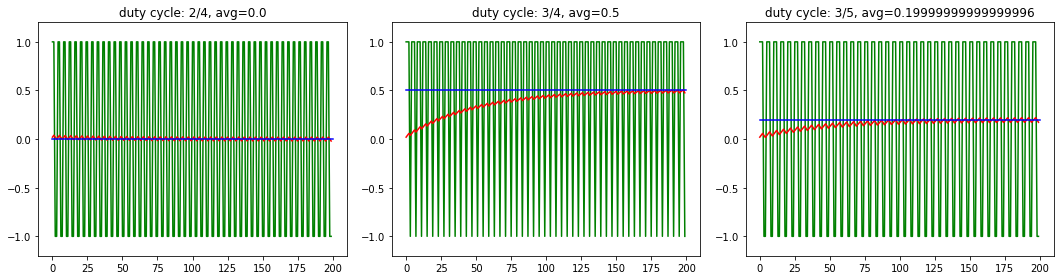

In [44]:
def square_wave_lp(P, D):
    # signal length
    N = 200
    
    # build one period of the square wave
    chunk = -np.ones(P)
    chunk[:D] = 1
    
    # build the full wave
    sw = np.tile(chunk, int(N / P))
    
    # now filter the square wave with a leaky integrator
    alpha = 0.98
    swf = sp.lfilter([1-alpha], [1, -alpha], sw)  # leaky integrator 低通濾波
    
    # average value
    A = 2.0 * float(D) / float(P) - 1  # duty cycle average = 2C-1

    plt.plot(sw, 'green', swf, 'red', [0, N], [A, A], 'blue')
    plt.ylim(-1.2, 1.2);
    plt.title('duty cycle: ' + str(D) + '/' + str(P) + ', avg=' + str(A))
    

plt.figure(figsize = (15, 4))    
    
plt.subplot(1, 3, 1)
square_wave_lp(4, 2)

plt.subplot(1, 3, 2)
square_wave_lp(4, 3)

plt.subplot(1, 3, 3)
square_wave_lp(5, 3)

plt.tight_layout()
plt.show()

#### Square wave
- duty cyle C = D/P
- average = (D*1 + (-1)*(P-D))/P = (2D-P)/P = 2D/P - 1 = 2C-1
- apply a leaky integrator to a square wave, equivlents to averaging.

Averaging (or lowpass filtering) a two-level square wave seems to be **a viable way to generate intermediate values between -1 and 1 using a two-level signal.** The technique goes under different names according to how you look at it: if the focus is on the correspondence between duty cycle and averaged value, the name of choice is **pulse width modulation**, since we're using the shape of the basic square wave pulse to generate the output. Another common term is **dithering**, which is borrowed from digital imaging; the origin of the name is [extremely fascinating](https://en.wikipedia.org/wiki/Dither) in and of itself.

So the question now is: where do we get a lowpass filter?

#### c) loudspeaker physics
A loudspeaker, especially a cheap one, will not be able to vibrate effectively at the low and high ends of the audible spectrum because of the physical limitations of its internal mechanics; at best the magnitude response will be flat up to 20KHz and decay rapidly afterwards. The lowpass characteristic of the loudspeaker is usually accentuated by the presence of limiting capacitors (as in the Spectrum schematics above) that prevent overloading the speaker's coil. 

So the lowpass is naturally present when driving a speaker with a square wave. The first spectral line in a square wave of period $P$ with a sampling frequency $F_s$ is going to be at $F_s/P$, independently of duty cycle. If we want to make sure that we don't hear any high-frequency artifacts when using the lowpass trick, we need to use square waves whose first harmonic falls outside of the frequency range of the loudspeaker. This is achieved by using oversampling.

#### d) oversampling
Even in early electronic devices, the CPU's clock was in the MHz range; that meant that the bit driving the loudspeaker could be flipped many times faster than the rate required to obtain a sound in the audible range. For instance, the ZX Spectrum's CPU (a Zilog Z80) ran at 3.5MHz; omitting boring details, that means one could output 1-bit samples at about 200KHz which represents a 10-time oversampling with respect to the bandwidth of the loudspeaker. Or, in other words, one could use square waves with varying duty cycles with a period up to 10 samples.

## 5 - Proof of concept

OK, let's apply the four concepts above to the PacMan jingle. We'll be working with contemporary PC hardware, so we can't simulate the high data rates we just discussed. However, assuming the highest sampling rate in your system's soundcard is 96KHz and seeing how we synthesized the PacMan jingle at 24KHz, we can obtain an upsampling factor of 4. 

Let's take the three-level jingle and replace all values like so:
 * $+2 \rightarrow [+1, +1, +1, +1]$
 * $-2 \rightarrow [-1, -1, -1, -1]$
 * $0 \rightarrow [+1, -1, +1, -1]$   ==>  這樣才能用 1-bit 去 encode 三種位準
 
With this, we'll obtain a signal that we can play at 96KHz; since the "fast" alternating segments are a wave with $P=2$, the corresponding first harmonic is at 48KHz and we should not be able to hear it.

In [45]:
# Over-sampling

v = 1
bits = 4
pacman1bit = np.ones(len(pacman) * bits)

for k in range(0, len(pacman)):
    if abs(pacman[k]) < 0.5: # floating tolerance
        pacman1bit[k*bits:(k+1)*bits] = [1, -1] * (bits//2)
    else:
        pacman1bit[k*bits:(k+1)*bits] = np.sign(pacman[k]) * np.ones(bits)
        
is_two_level(pacman1bit)

the signal is  two-level; values:
[-1.0, 1.0]


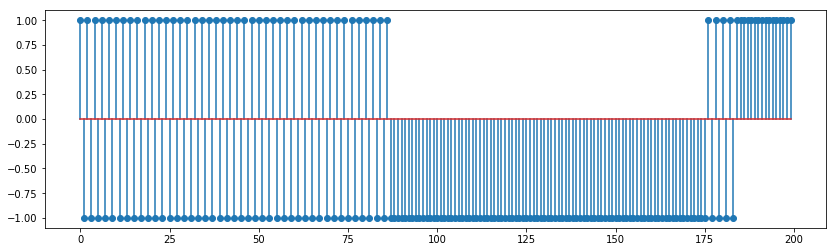

In [46]:
plt.stem(pacman1bit[600:800]);

OK, the signal is two-level. We can compare the original and the 1-bit version:

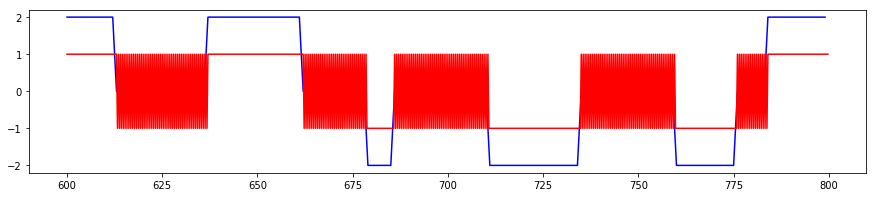

In [47]:
a = 600
b = 800

plt.figure(figsize = (15, 3))    
    
plt.plot(np.arange(a,b), pacman[a:b], 'blue', 
         np.arange(a*bits,b*bits)/bits, pacman1bit[a*bits:b*bits], 'red')

plt.ylim(-2.2, 2.2);

And finally we can play it. And it works!!!

In [48]:
IPython.display.Audio(pacman1bit, rate=96000 / 4 * bits)

Here, for reference, is the original once again:

In [49]:
IPython.display.Audio(pacman, rate=24000)

## 6 - Four-Part Harmony

We can try and generalize the above approach to more that two voices, although we won't be able to go very far using the standard Python audio interface. 

The first thing to notice is that, if we sum $N$ square waves together, the resulting signal will contain up to $N+1$ levels with values in the following set:

$$
    -N, -(N-2), \ldots, (N-2), N
$$

To map this onto a 1-bit signal, we will require at least an oversampling factor of $N$, since a square wave period of length $N$ allows for $N+1$ different duty cycles (and therefore, when averaged, $N+1$ output values).

Let's try and write a function that does this generic mapping for us and apply it to a famous bit of 4-part  music. Since we have four voices and our maximum sampling rate is 96KHz, we need to synthesize it at 24KHz; we will use the "expensive" square wave generator to minimize detuning.

![Bist Du bei Mir](bdbm.png)

In [50]:
bdbm_1 = (('Bb4', 4), ('Eb5', 6), ('F5', 2), ('D5', 8), (' ', 4),  
          ('Eb5', 4), ('Ab4', 4), ('Ab4', 4), ('Ab4', 8), ('G4', 4), 
          (' ', 2), ('Bb4', 2), ('D5', 2), ('Bb4', 2), ('A4', 2), ('Bb4', 2), 
          ('F4', 2), ('Bb4', 2), ('D5', 2), ('Bb4', 2), ('A4', 2), ('Bb4', 2), 
          ('Eb4', 4), ('C5', 6), ('D5', 1), ('Eb5', 1),
          ('D5', 3), ('C5', 1), ('Bb4', 3), ('C5', 1), ('F4', 3), ('A4', 1), 
          ('Bb4', 12), )

bdbm_2 = (('G4', 4), ('G4', 4), ('A4', 4), ('Bb4', 8), (' ', 4), ('Bb4', 4), 
          ('F4', 4), ('F4', 4), ('F4', 8), (' ', 4), ('G4', 12), ('F4', 12), 
          (' ', 12), (' ', 8), ('Eb4', 4), (' ', 12),)  

bdbm_3 = ((' ', 12), ('F4', 8), (' ', 4), ('Eb4', 4), ('F4', 4), ('C3', 4), 
          ('Bb3', 4), ('D4', 4), ('Eb4', 4), (' ', 12), ('D4', 12), ('Bb3', 4), 
          ('F4', 4), ('A4', 4), ('Bb4', 4), ('G4', 4), ('Eb4', 4), ('D4', 12),  )

bdbm_4 = (('Eb3', 4), ('C3', 4), ('F3', 4), ('Bb2', 4), ('Bb3', 4), ('Ab3', 4), 
          ('G3', 4), ('F3', 4), ('Eb3', 4), ('D3', 4), ('Bb2', 4), ('Eb2', 4), 
          ('E2', 4), ('E2', 4), ('E2', 4), ('F2', 4), ('F2', 4), ('F2', 4), 
          ('G2', 4), ('A2', 4), ('F2', 4), ('Bb2', 4), ('Eb2', 4), ('F2', 4), ('Bb2', 12), )

SF=24000
s  = play_notes(bdbm_1, time_scale=0.2, rate=SF, wave_engine=square_wave_exact)
s += play_notes(bdbm_2, time_scale=0.2, rate=SF, wave_engine=square_wave_exact)
s += play_notes(bdbm_3, time_scale=0.2, rate=SF, wave_engine=square_wave_exact)
s += play_notes(bdbm_4, time_scale=0.2, rate=SF, wave_engine=square_wave_exact)

IPython.display.Audio(s, rate=SF)

In [51]:
SF

24000

Here is the generic "dithering" function to convert the audio to 1 bit:

In [52]:
def dither(waveform, rate):
    
    MAX_RATE = 96000
    values = distinct_values(waveform)
    voices = len(values) - 1 
    
    if (rate * voices) > MAX_RATE:
        print('cannot dither: it would require too large a sampling rate')
        return None
    
    for n in range(0, voices):
        if not (-voices + 2*n) in values:
            print('signal does not seem to be the sum of ', voices, 'square waves')
            return None
        
    s = np.zeros(len(waveform) * voices)
    
    # now replace each sample with one period of a square wave with appropriate duty cycle
    for n in range(0, len(waveform)):
        
        # let's start with a duty cycle of 100%
        chunk = np.ones(voices)
        
        if waveform[n] < 0:
            chunk = -chunk
            
        # let's distribute the transitions evenly over the period
        flips = int((voices - abs(waveform[n])) / 2)
        chunk[0:2*flips:2] *= -1
        s[n*voices:(n+1)*voices] = chunk
    
    return s, rate * voices 

In [53]:
def dither_flip(d):
    voices = 4
    chunk = np.ones(voices)

    if d < 0:
        chunk = -chunk

    # let's distribute the transitions evenly over the period
    flips = int((voices - abs(d)) / 2)
    chunk[0:2 * flips:2] *= -1
    return chunk
    
for d in [-4, -2, 0, 2, 4]:
    print(dither_flip(d))

[-1. -1. -1. -1.]
[ 1. -1. -1. -1.]
[-1.  1. -1.  1.]
[-1.  1.  1.  1.]
[1. 1. 1. 1.]


Let's process the four-part audio, verify it's two-level and let's play it at the oversampled rate:

In [54]:
sd, drate = dither(s, SF)

is_two_level(sd)

IPython.display.Audio(sd, rate=drate) 

the signal is  two-level; values:
[-1.0, 1.0]


In [55]:
drate

96000

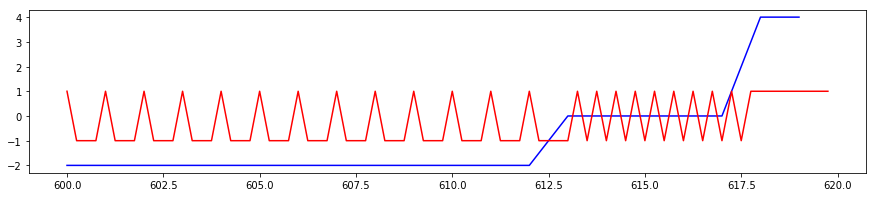

In [56]:
a = 600
b = 620

plt.figure(figsize = (15, 3))    
    
plt.plot(np.arange(a,b), s[a:b], 'blue', 
         np.arange(a*bits,b*bits)/bits, sd[a*bits:b*bits], 'red');

When the number of voices increases, unless we can oversample more we will start to hear artifacts due to the fact that **the number of periods of the "fast" square wave pieces are not long enough for the implicit loudspeaker lowpass to converge to the mean**. We can "help" the process by explicitly lowpass filtering the 1-bit signal and it does sound better, although of course the higher harmonics in the frequency content are attenuated:

In [57]:
b, a = sp.butter(8, 0.15)
IPython.display.Audio(sp.lfilter(b, a, sd), rate=drate)   

## 7 - Brandenburg Concerto

In this last section we will look at ways to **encode *generic* audio files at one bit per sample**. The classic *uncompressed* encoding for sampled audio is **PCM** (the format in WAV files) where each sample is quantized over $R$ bits, with typically $R=16$. If we want to avoid a loss of audio quality, reducing the per-sample precision will require an increase in the sampling rate, just like in dithering. Ideally, we would like to retain the same overall data rate so that, from an original PCM at $F_s$ samples per second and $R$ bits per sample, we should not need more than a $RF_s$ one-bit samples per second. 

Since now we're moving away from the videogame-centric landscape we've lived in so far, it's perhaps useful to remember why we are interested in 1-bit audio:

 * 1-bit streams, being highly oversampled, are easy to convert to analog, since they require just a simple lowpass filter (just like in the dithering examples). As a matter of fact, the D/A's in smartphones, tablets and PCs all use 1-bit conversion prior to analog interpolation
 * 1-bit streams are easy to transmit over links such as USB and fiber optics, since they require no reframing
 * very efficient hardware exists to convert PCM data into 1-bit data and vice-versa 
 
In general the setup will be the following, where the bottom line indicates the resolution and rate of the intermediate signals:

![setup](setup.png)

In order to use as large a factor as possible within the limitations of the notebook format, we'll start with a 16bps mono PCM audio file sampled at 8KHz ([source](https://en.wikipedia.org/wiki/Switched-On_Brandenburgs)):

In [58]:
from scipy.io import wavfile

_, s8 = wavfile.read('brand1.wav')
IPython.display.Audio(s8, rate=8000)

In [59]:
s8.dtype

dtype('int16')

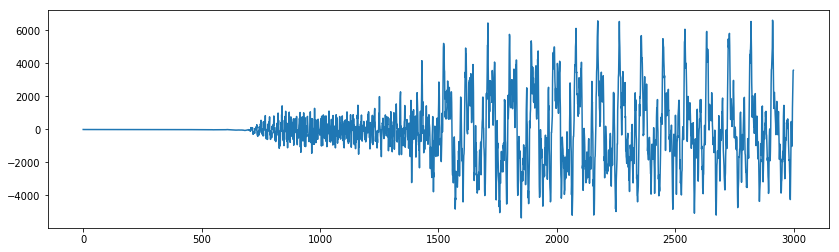

In [60]:
plt.plot(s8[:3000]);

Let's define some auxiliary functions and import a multirate signal processing module that provides us with basic interpolation and decimation routines (documentation [here](http://mubeta06.github.io/python/sp/_modules/sp/multirate.html)):

In [61]:
import multirate as mr

def renormalize(x):
    # remove DC and normalize signal between -1 and +1
    x = x - np.mean(x)
    x = x / np.max(np.abs(x))
    return x


def quantize_1(x):
    # quantize a signal at 1 bps
    return np.where(renormalize(x) < 0, -1, 1)


def quantize_R(x, R):
    # quantize a signal at R bps
    A = int(pow(2, R-1))
    return np.floor(A * (1 + 0.999 * renormalize(x))) - A + 0.5

As a reference point, let's hear what happens if we just downsample the original signal to one bit per sample: it's just awful.

In [62]:
IPython.display.Audio(quantize_1(s8), rate=8000)

### a) limits of dithering

The dithering strategy used in the previous sections worked well because we applied it to signals which were sums of square waves, i.e. piecewise-constant waveforms. In those cases we could replace segments of the signal by faster square waves with appropriate duty cycles. 

In a $R$-bps PCM signal, the samples will take on $2^R$ possible values. To apply standard dithering, we should upsample the signal at least $M=2^R$ times and follow with a zero-order interpolator to obtain a suitable piecewise-constant waveform. It's easy to see that even for even moderate values of $R$, the oversampling factor becomes too large. 

### b) limits of standard oversampling

If we look at 1-bit encoding as a standard quantization problem we can write

$$ \hat{x}_{\mathrm{1B}}[n] = \mathcal{Q}\{x[n]\} = x[n] + e[n] $$

with $\hat{x}_{\mathrm{1B}}[n] \in \{-1, +1\}$; the goal is to minimize the quantization error $e[n]$. 

The principle behind oversampled A/D is simple: suppose the noise is independent of the signal and of the sampling rate. If we sample faster than necessary, a subsequent downsampling operation (i.e. lowpass plus decimation) is equivalent to "averaging" samples toghether and this will reduce the quantization noise. In the frequency domain, this is described as an unchanging noise floor introduced by the quantizer plus a signal spectrum that shrinks with increasing oversampling. Lowpass filtering can remove the out-of-band noise and yield a higher SNR.

![oversampled](oversampled.png)

In its simplest form, the theory us that an oversampling factor of $K$ will yield $\log_4 K$ extra bits of resolution. Even neglecting the law of diminishing returns that plagues oversampled A/D, in order to obtain 16 bits of equivalent resolution for a 1-bit stream, we should oversample over a *billion* times! Clearly not practical.

We can verify that oversampling does indeed work, although not at the levels we need; here for instance you can listen to the result for $K=12$:

In [63]:
s_over = quantize_1(mr.interp(s8, 12, l=20, alpha=0.95))  # oversample and quantize to 1 bit
is_two_level(s_over)

the signal is  two-level; values:
[-1, 1]


C:\Softwares\Python\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


We can now eliminate the out-of-band quantization noise and play the result:

In [64]:
b, a = sp.butter(8, 0.08)
IPython.display.Audio(sp.lfilter(b, a, s_over), rate=96000)    

Although the total data rate of the file is equivalent to a 12-bps PCM signal, the audio quality is between a a 2-bps and a 3-bps signal as predicted by the theory:

In [65]:
IPython.display.Audio(quantize_R(s8, 2), rate=8000)  # 2 bps

In [66]:
IPython.display.Audio(quantize_R(s8, 3), rate=8000)  # 3 bps

### c) sigma delta

There is still one powerful tool to try, namely introducing **feedback** in the quantization process. Both dithering and oversampling are simple **feedforward** methods for which the quantization error only depends on the current input value. By introducing a feedback loop into the quantizer, we can adjust the output values to minimize the overall error ***adaptively***. 

The most common adaptive quantization scheme is called **"sigma-delta"**. Here we will describe the process in a purely digital setup, where we use it to reduce the sample resolution in exchange for a higher sample rate; in practice, sigma-delta converters are commonly used in A/D and D/A applications. 

In dithering a sum of square waves, we were exploting the piecewise-constant nature of the oversampled signal: we replaced each "flat" segment of the input with a faster square wave whose period average was equal to the (constant) value of the segment.

In sigma-delta the principle is the same, except that the input is no longer piecewise constant; therefore we generate a non-periodic two-level signal **whose local average tracks the local average of the input signal**. To do so, at each quantization step we compute the difference between the running average of the input and the running average of the output; if the difference is positive, we output a +1, otherwise a -1.

Since the difference of the averages is the average of the difference, the sigma-delta circuit is simply:

![sigma delta](sigmadelta.png)

where $H(z)$ is an averaging filter, i.e. a lowpass. For simplicity we can use the simplest discrete-time lowpass, namely a simple integrator whose transfer function is

$$
    H(z) = \frac{1}{1-z^{-1}}
$$

The algorithm is very simple and can be implemented in a couple of lines:

C:\Softwares\Python\lib\site-packages\scipy\signal\filter_design.py:446: RuntimeWarning: divide by zero encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
C:\Softwares\Python\lib\site-packages\scipy\signal\filter_design.py:446: RuntimeWarning: invalid value encountered in true_divide
  npp_polyval(zm1, a, tensor=False))
C:\Softwares\Python\lib\site-packages\numpy\lib\function_base.py:1402: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd + pi, 2*pi) - pi
C:\Softwares\Python\lib\site-packages\numpy\lib\function_base.py:1403: RuntimeWarning: invalid value encountered in greater
  _nx.copyto(ddmod, pi, where=(ddmod == -pi) & (dd > 0))
C:\Softwares\Python\lib\site-packages\numpy\lib\function_base.py:1405: RuntimeWarning: invalid value encountered in less
  _nx.copyto(ph_correct, 0, where=abs(dd) < discont)


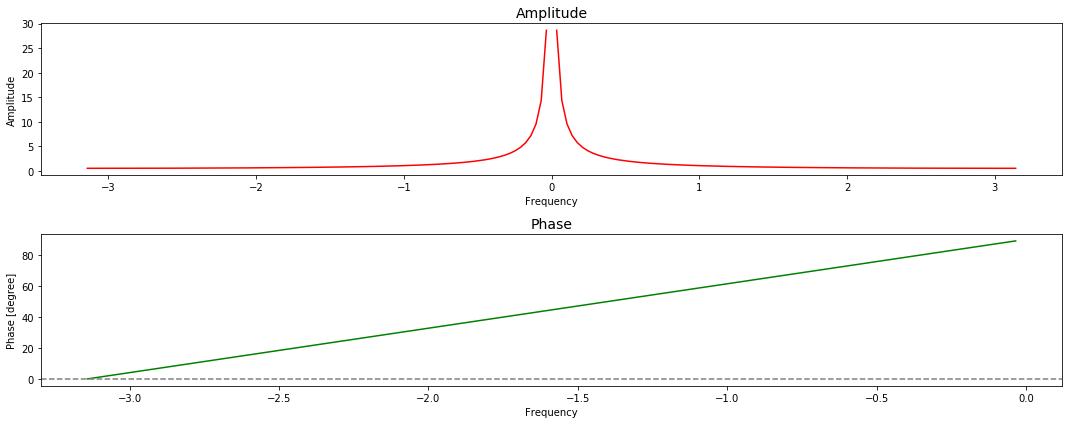

In [67]:
_ = filtering.get_H_from_polynomials(polynomials_denom = [[1, -1]], plot = True)

In [68]:
def sigma_delta(x, acc=0):
    ret = np.zeros(len(x))
    for n in range(0, len(x)):
        ret[n] = 1 if acc >= 0 else -1
        acc += x[n] - ret[n]
    return ret


# oversample 12 times
s96 = renormalize(mr.interp(s8, 12, l=20, alpha=0.95))
s96_sd = sigma_delta(s96)
is_two_level(s96_sd)

the signal is  two-level; values:
[-1.0, 1.0]


We can try to play the sigma-delta signal directly but, because of the low initial sampling frequency, a lot of noise remains in the audio band; it's better therefore to filter the signal with a lowpass with cutoff $\pi/K$. We can hear that the audio quality is quite acceptable (we are operating at an equivalent rate of 12 bits per sample):

In [69]:
IPython.display.Audio(s96_sd, rate=96000)   

In [70]:
b, a = sp.butter(8, 0.08)
IPython.display.Audio(sp.lfilter(b, a, s96_sd), rate=96000)   

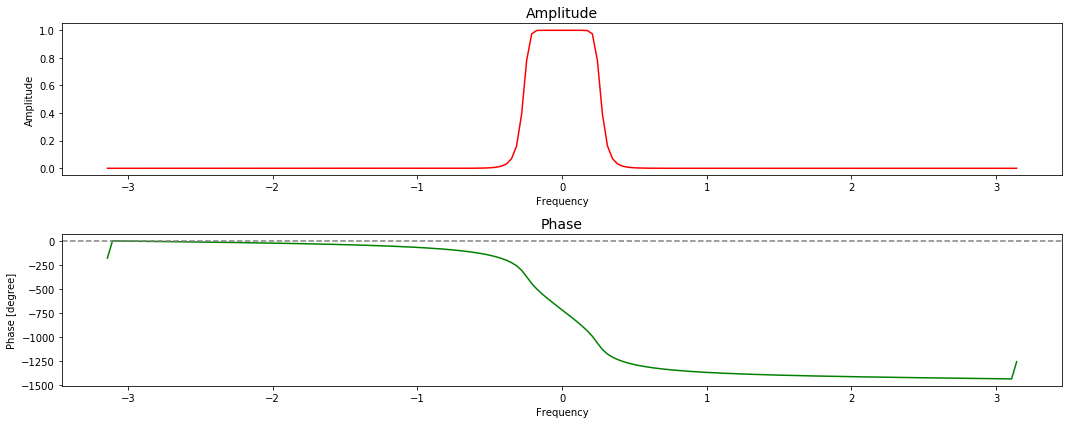

In [71]:
# Butterworth filter
_ = filtering.get_H_from_polynomials([b], [a], plot = True)

### d) higher-order sigma-delta

Sigma-delta circuits are hard to analyze from the theoretical point of view because of the strong nonlinearity introduced by the 1-bit quantization. However, if we (quite unrealistically) model quantization error $e[n] = x_{\mathrm{1B}}[n] - x[n]$ as an additive, independent noise source, we can "rewrite" the feedback loop like so:

![linearized](sigmadeltalinearized.png)

In the $z$-domain the input-output relation becomes:

\begin{align*}
    Y(z) &= \frac{H(z)}{1+H(z)}X_K(z) + \frac{1}{1+H(z)}E(z) \\ \\
         &= F(z)X_K(z) + G(z)E(z) 
\end{align*}

If we choose $H(z) = 1/(1-z^{-1})$, i.e. a standard integrator, we have that the *signal* transfer function is 

$$
    F(z) = \frac{1}{2-z^{-1}}
$$
whereas the *noise* transfer function is 
$$
    G(z) = \frac{1 - z^{-1}}{2-z^{-1}}
$$

The frequency response of each filter is plotted below. For high oversampling factors, i.e. for input signals that occupy just a small portion of the baseband spectrum, $F(z)$ acts as an allpass while $G(z)$ acts as a highpass, killing most of the quantization noise in the band of interest; the band is shown in green for our oversampling factor $K=12$.

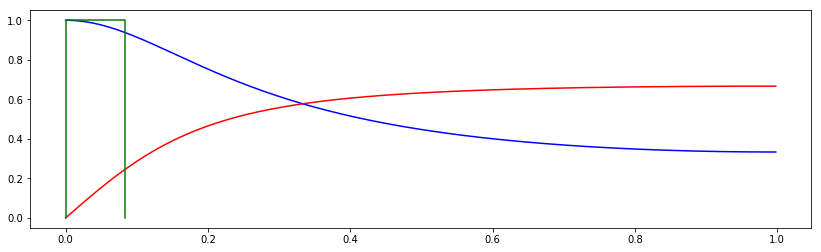

In [72]:
w, f = sp.freqz([1, ], [2, -1])
w, g = sp.freqz([1, -1], [2, -1])

plt.plot(w / np.pi, abs(f), 'b', 
         w / np.pi, abs(g), 'r',
         [0, 0, 1.0/12.0, 1.0/12.0], [0, 1, 1, 0], 'g');

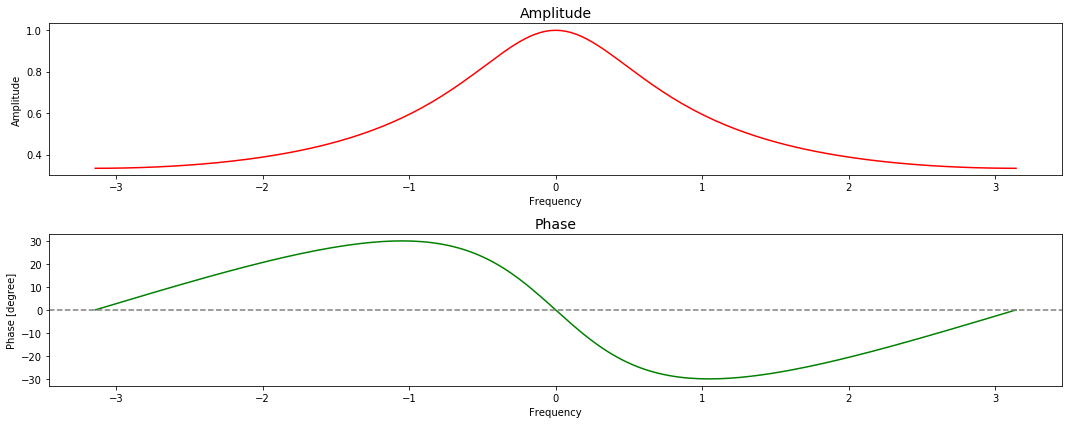

In [73]:
# 𝐹(𝑧)
_ = filtering.get_H_from_polynomials([[1]], [[2, -1]], plot = True)

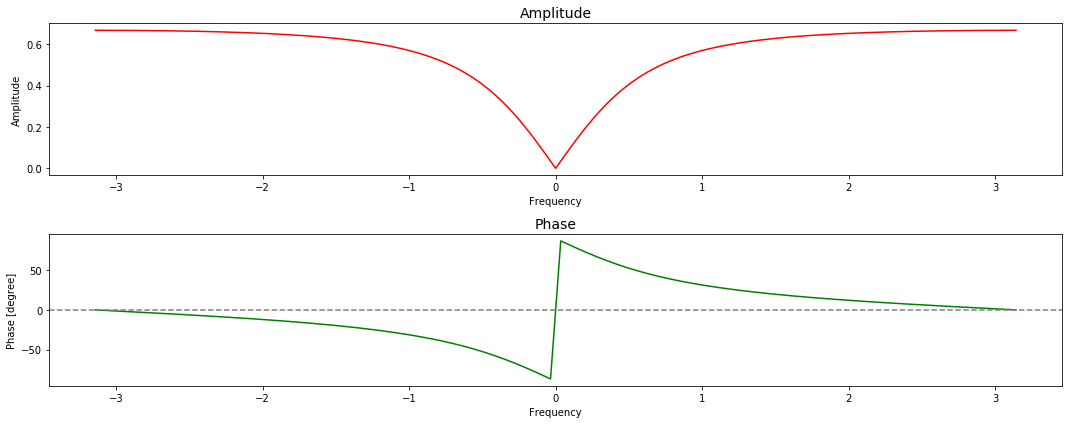

In [74]:
# 𝐺(𝑧)
_ = filtering.get_H_from_polynomials([[1, -1]], [[2, -1]], plot = True)

In order to increase the overall performance, higher order sigma delta loops have been designed. The exact analysis of these systems is even more complex but the principle remains the same: obtain **a flat in-band response** for the signal transfer function and **maximize the noise rejection** by an equivalent sharp highpass characteristic for the noise transfer function in the feedback loop. 

The second-order sigma-delta is shown in the following figure and easily implemented in the function below:

![second order sigma delta](sigmadeltasecond.png)

In [75]:
def sigma_delta2(x, acc1=0, acc2=0):
    ret = np.zeros(len(x))
    y = np.sign(acc2)
    for n in range(0, len(x)):
        acc1 += (x[n] - y)
        acc2 += (acc1 - y)
        ret[n] = y = np.sign(acc2)
    return ret


s96_sd2 = sigma_delta2(s96)
is_two_level(s96_sd2)

the signal is  two-level; values:
[-1.0, 1.0]


We can hear that a second-order quantizer yields significant improvement in audio quality:

In [76]:
IPython.display.Audio(sp.lfilter(b, a, s96_sd2), rate=96000)

In fact, the quality is not very far from a 12-bps PCM signal:

In [77]:
IPython.display.Audio(quantize_R(s8, 12), rate=8000)

As a comparison point, the [Super Audio CD](https://en.wikipedia.org/wiki/Super_Audio_CD) format uses a fifth-order sigma-delta converter with an oversampling factor of 64.

## References

http://www.rane.com/note137.html : a gentle introduction to A/D and D/A conversion techniques

http://www.ti.com/lit/an/slyt423/slyt423.pdf : a technical paper on sigma-delta converters